## <div style="color:white;display:fill;border-radius:5px;background-color:#264653;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:120%">0.0 Imports and Settings</p></div>


In [1]:
import pandas             as pd
import numpy              as np
import seaborn            as sns
import scikitplot         as skplt
import matplotlib.pyplot  as plt
%matplotlib inline
import sweetviz           as sv
import inflection
import optuna
import pickle
import shap
from shap import plots

from IPython.display          import HTML
from watermark                import watermark 
from sklearn                  import metrics                   as mt
from sklearn                  import model_selection           as ms
from sklearn                  import preprocessing             as pp
from sklearn                  import neighbors                 as nh
from sklearn                  import linear_model              as lm
from sklearn.ensemble         import RandomForestClassifier
from lightgbm                 import LGBMClassifier, plot_importance
from xgboost                  import XGBClassifier
from sklearn.model_selection  import cross_val_score, cross_val_predict, KFold, cross_validate, StratifiedKFold
from sklearn.metrics          import  roc_auc_score
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


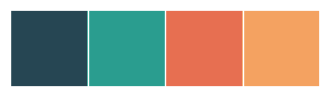

In [2]:
# configurações globais para gŕaficos
sns.set_theme()                                                   
plt.rcParams['figure.figsize'] = [12, 6]                         

LAYOUT_PALETTE = ["#264653","#2a9d8f","#e76f51","#f4a261"]
sns.set_palette(sns.color_palette(LAYOUT_PALETTE))

cm = sns.light_palette("#264653")

sns.palplot(sns.color_palette(LAYOUT_PALETTE))

cores = ["#264653","#f4a261","#e76f51","#2a9d8f"]

In [3]:
print(watermark())

Last updated: 2023-12-18T22:05:47.839884-03:00

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.15.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : AMD64 Family 23 Model 8 Stepping 2, AuthenticAMD
CPU cores   : 12
Architecture: 64bit



In [4]:
print(watermark(packages="pandas,numpy,seaborn,matplotlib,optuna,scikit-learn,lightgbm,xgboost,shap,watermark,flask,scipy"))

pandas      : 2.0.3
numpy       : 1.25.2
seaborn     : 0.12.2
matplotlib  : 3.8.0
optuna      : 3.4.0
scikit-learn: 1.3.0
lightgbm    : 4.1.0
xgboost     : 2.0.1
shap        : 0.44.0
watermark   : 2.4.3
flask       : 3.0.0
scipy       : 1.11.1



## <div style="color:white;display:fill;border-radius:5px;background-color:#264653;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:120%">0.1 Helper Functions</p></div>

In [5]:
def precision_at_k( data, k):
    # reset index
    data = data.reset_index( drop=True)

    # created ranking order
    data['ranking'] = data.index + 1

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']

def recall_at_k( data, k):
    # reset index
    data = data.reset_index( drop=True)

    # created ranking order
    data['ranking'] = data.index + 1

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']

def modelo_metricas(nome_modelo, y_val, yhat, X_validation):
    #copy data
    df7 = X_validation.copy()
    df7['response'] = y_val.copy()
    #Propensity score
    df7['score'] = yhat[:, 1].tolist()
    #Sorted clients by propensity score
    df7 = df7.sort_values( 'score', ascending=False)
    # Tabela com metricas
    precision = precision_at_k(df7, 4000)
    recall = recall_at_k(df7, 4000)
    auc_score = mt.roc_auc_score(y_val, yhat[:,1])
    
    return pd.DataFrame({'Model Name': nome_modelo,
                         'ROC AUC at K': auc_score,
                         'Precisão at K': precision,
                         'Recall at K': recall}, index=[0])

def cross_validation(X_train, y_train, k_folds, model_name, model):

    df_list = []
    df_concat = pd.DataFrame()
    
    for k in range(k_folds):
        
        x_train_cv, x_val_cv, y_train_cv, y_val_cv = ms.train_test_split(X_train, y_train, test_size=0.2, random_state=k)

        x_train_cv = x_train_cv.loc[:,cols_selected]
        x_val_cv = x_val_cv.loc[:,cols_selected]

        x_validation_cv = x_val_cv.copy()
        x_validation_cv['response'] = y_val_cv.copy()

        #model
        m = model

        #training
        m.fit(x_train_cv, y_train_cv)

        #prediction
        yhat = m.predict_proba(x_val_cv)

        #performance
        df_metrics = modelo_metricas(model_name, y_val_cv, yhat, x_validation_cv)
        df_list.append(df_metrics)
        
    
    df_concat = pd.concat(df_list, ignore_index=True)
    
    return df_concat

def rename_columns( df_train ):
    cols_old = df_train.columns

    cols_new = []
    cols_new = cols_old.map(lambda x: inflection.underscore(x))

    df_train.columns = cols_new
    
    return df_train

def feature_engineering( df1 ):
        # vehicle_age
        df1['vehicle_age'] = df1['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year')

        # vehicle_damage
        df1['vehicle_damage'] = df1['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )
        
        return df1

def data_rescaling( df3 ):
    
    ss = pp.StandardScaler()
    mms_age = pp.MinMaxScaler()
    mms_vintage = pp.MinMaxScaler()

    #annual_premium
    df3['annual_premium'] = ss.fit_transform( df3[['annual_premium']].values )
    pickle.dump( ss, open('../src/features/annual_premium_scaler.pkl', 'wb'))
    #age
    df3['age'] = mms_age.fit_transform( df3[['age']].values )
    pickle.dump( mms_age, open('../src/features/age_scaler.pkl', 'wb'))
    #vintage
    df3['vintage'] = mms_vintage.fit_transform( df3[['vintage']].values )
    pickle.dump( mms_vintage, open('../src/features/vintage_scaler.pkl', 'wb'))

    return df3 

def data_encoding( df3 ):
    
    # gender - Label Encoder
    gender_dict = {'Male': 0, 'Female': 1}
    df3['gender'] = df3['gender'].map( gender_dict )

    #region_code - Frequency Encoding 
    fe_encode_region_code = df3.groupby( 'region_code' ).size() / len (df3)
    df3.loc[ : , 'region_code'] = df3['region_code'].map( fe_encode_region_code )
    pickle.dump( fe_encode_region_code, open('../src/features/encode_region_code.pkl', 'wb'))

    #vehicle_age - Ordinal Encoding  
    vehicle_age_dict = {'below_1_year': 1, 'between_1_2_year': 2, 'over_2_years': 3}
    df3['vehicle_age'] = df3['vehicle_age'].map( vehicle_age_dict )

    # policy_sales_channel  *Frequency Encoding 
    fe_encode_policy = df3.groupby( 'policy_sales_channel' ).size() / len (df3)
    df3.loc[ : , 'policy_sales_channel'] = df3['policy_sales_channel'].map( fe_encode_policy )
    pickle.dump( fe_encode_policy, open('../src/features/encode_policy.pkl', 'wb'))

    return df3 

## <div style="color:white;display:fill;border-radius:5px;background-color:#264653;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:120%">0.2 Loading Data</p></div>

In [6]:
data_train_raw = pd.read_csv('../dataset/train.csv')

In [7]:
data_train_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [8]:
# Dropa a variavel resposta
X = data_train_raw.drop( columns='Response')
y = data_train_raw['Response'].copy()

# separação entre treino(80%) e teste(20%)
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size = 0.20, random_state = RANDOM_SEED)

In [9]:
data_train_raw = X_train
data_train_raw['Response'] = y_train

## <div style="color:white;display:fill;border-radius:5px;background-color:#264653;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:120%">1.0 Data Description</p></div>

In [10]:
df_train = data_train_raw.copy()

#### <div style="color:white;display:fill;border-radius:5px;background-color:#f4a261;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:80%">1.1 Rename Columns</p></div> 

In [11]:
# Renomeia as colunas
df_train = rename_columns( df_train )

#### <div style="color:white;display:fill;border-radius:5px;background-color:#f4a261;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:80%">1.2 Columns Description</p></div> 

In [12]:
df_train.shape, X_test.shape

((304887, 12), (76222, 11))

In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 304887 entries, 332803 to 121958
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    304887 non-null  int64  
 1   gender                304887 non-null  object 
 2   age                   304887 non-null  int64  
 3   driving_license       304887 non-null  int64  
 4   region_code           304887 non-null  float64
 5   previously_insured    304887 non-null  int64  
 6   vehicle_age           304887 non-null  object 
 7   vehicle_damage        304887 non-null  object 
 8   annual_premium        304887 non-null  float64
 9   policy_sales_channel  304887 non-null  float64
 10  vintage               304887 non-null  int64  
 11  response              304887 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 30.2+ MB


In [14]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76222 entries, 200222 to 185839
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    76222 non-null  int64  
 1   Gender                76222 non-null  object 
 2   Age                   76222 non-null  int64  
 3   Driving_License       76222 non-null  int64  
 4   Region_Code           76222 non-null  float64
 5   Previously_Insured    76222 non-null  int64  
 6   Vehicle_Age           76222 non-null  object 
 7   Vehicle_Damage        76222 non-null  object 
 8   Annual_Premium        76222 non-null  float64
 9   Policy_Sales_Channel  76222 non-null  float64
 10  Vintage               76222 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 7.0+ MB


#### <div style="color:white;display:fill;border-radius:5px;background-color:#f4a261;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:80%">1.3 Descriptive Statistics </p></div> 


In [15]:
num_atributes = df_train.select_dtypes( include=['int64', 'float64'])
cat_atributes = df_train.select_dtypes( exclude=['int64', 'float64'])

#### <div style="color:white;display:fill;border-radius:5px;background-color:#f4a261;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:80%">1.3.1 Numerical Attributes </p></div> 


In [16]:
num_atributes.describe()

,id,age,driving_license,region_code,previously_insured,annual_premium,policy_sales_channel,vintage,response
count,304887.000000,304887.000000,304887.000000,304887.000000,304887.000000,304887.000000,304887.000000,304887.000000,304887.000000
mean,190594.098072,38.835582,0.997829,26.413340,0.458373,30571.851319,111.966591,154.272609,0.121970
std,110022.144283,15.509522,0.046547,13.218019,0.498265,17254.243887,54.230069,83.642389,0.327251
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95342.500000,25.000000,1.000000,15.000000,0.000000,24406.500000,26.000000,82.000000,0.000000
50%,190639.000000,36.000000,1.000000,28.000000,0.000000,31675.000000,131.000000,154.000000,0.000000
75%,285785.500000,49.000000,1.000000,35.000000,1.000000,39414.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


#### <div style="color:white;display:fill;border-radius:5px;background-color:#f4a261;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:80%">1.3.2 Categorical Attributes </p></div> 


<Axes: xlabel='vehicle_damage', ylabel='response'>

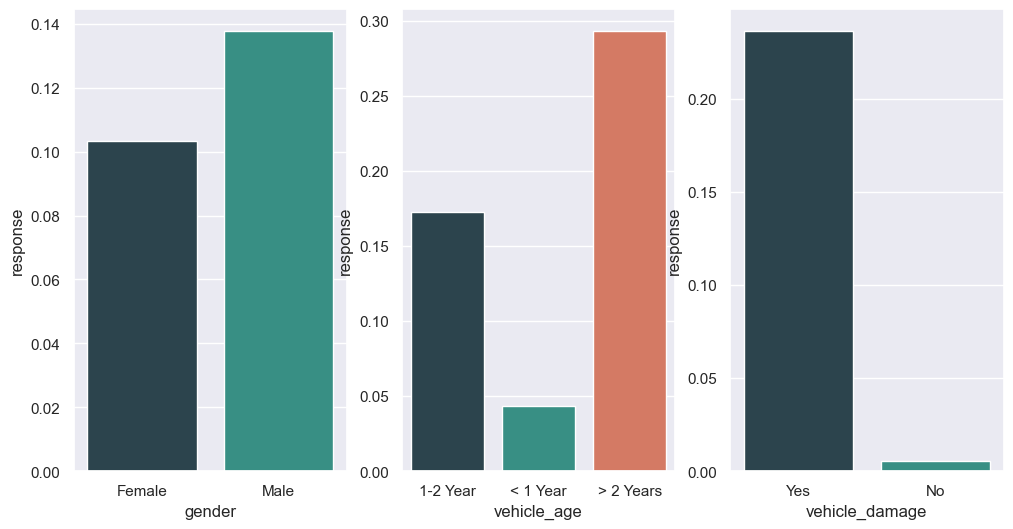

In [17]:
plt.subplot(1,3,1)
sns.barplot(x='gender', y='response', data=df_train, errorbar=None)

plt.subplot(1,3,2)
sns.barplot(x='vehicle_age', y='response', data=df_train, errorbar=None)

plt.subplot(1,3,3)
sns.barplot(x='vehicle_damage', y='response', data=df_train, errorbar=None)

## <div style="color:white;display:fill;border-radius:5px;background-color:#264653;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:120%">2.0 Feature Engineering</p></div>

In [18]:
df1 = df_train.copy()

In [19]:
df1 = feature_engineering( df1 )

#### <div style="color:white;display:fill;border-radius:5px;background-color:#f4a261;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:70%">2.1 Hipóteses de Negócio</p></div> 

1. Clientes mais novos têm maior interesse em adquirir seguro veicular??
2. Clientes com CNH têm maior propensão para adquirir o seguro?
3. Clientes que já possuem seguro são mais propensos a adquirir outro seguro?
4. O preço do seguro de veículo tem alguma influência? Preços ou planos específicos são fatores importantes para conquistar os clientes?
5. O canal de contato com o cliente tem influência sobre o interesse no seguro?
6. O gênero do cliente pode ser um fator de influência, existe diferença na propensão a adquirir um seguro de veículo?

## <div style="color:white;display:fill;border-radius:5px;background-color:#264653;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:120%">3.0 Exploratory Data Analysis</p></div>

In [20]:
df2 = df1.copy()

In [21]:
#my_report = sv.analyze( df_train, target_feat='response')
#my_report.show_html()

### <div style="color:white;display:fill;border-radius:5px;background-color:#e76f51;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:100%">3.1 Análise Univariada</p></div>

#### <div style="color:white;display:fill;border-radius:5px;background-color:#f4a261;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:70%">Variável Resposta</p></div> 

Cliente não Interessado: 267700
Cliente Interessado: 37187


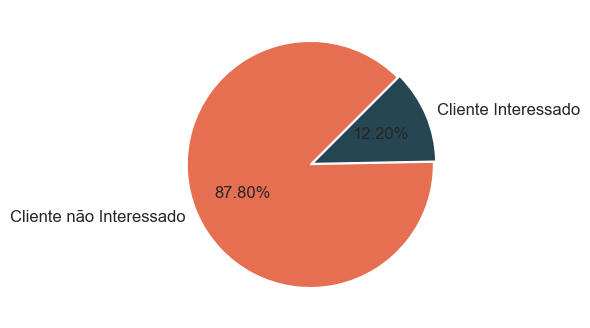

In [22]:
# response
count_class_0 = len(df2[df2['response'] == 0])
count_class_1 = len(df2[df2['response'] == 1])
aux = [count_class_0, count_class_1]

plt.figure(figsize=(8, 4))
plt.pie(aux,
        labels=['Cliente não Interessado', 'Cliente Interessado'],
        colors=['#e76f51', '#264653'],
        explode=(0.01, 0.01),
        startangle=45,
        autopct='%.2f%%',
        wedgeprops={'linewidth': 1, 'edgecolor': "white"},
        textprops={'fontsize': 12});

#print(f"Cliente não interessado: {df2['response'].value_counts[0]}")
#print(f"Cliente interessado: {df2['response'].value_counts()[1]}")

print(f"Cliente não Interessado: {count_class_0}")
print(f"Cliente Interessado: {count_class_1}")


#### <div style="color:white;display:fill;border-radius:5px;background-color:#f4a261;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:70%">Variáveis Numéricas</p></div> 

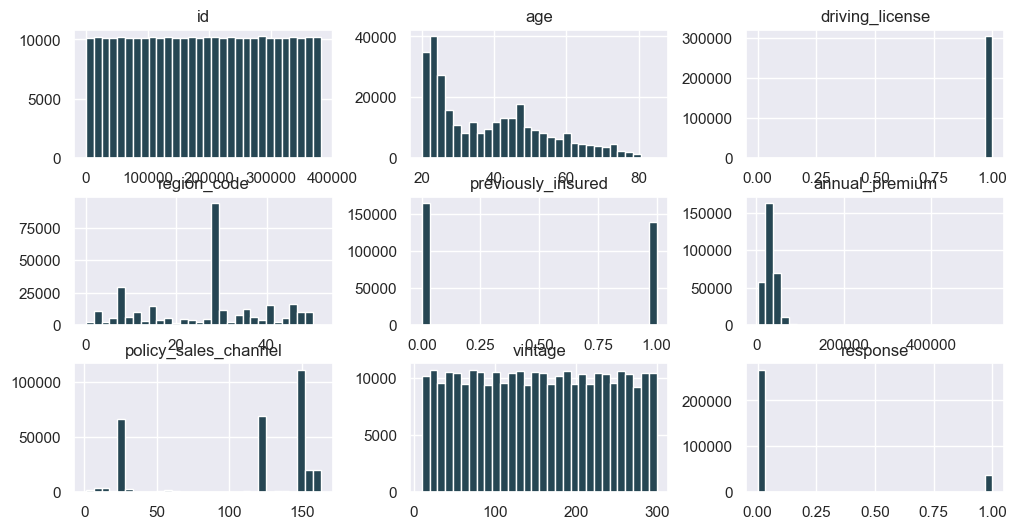

In [23]:
num_atributes.hist( bins=30);

#### <div style="color:white;display:fill;border-radius:5px;background-color:#f4a261;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:70%">Variáveis Categóricas</p></div> 

<Axes: xlabel='response', ylabel='Density'>

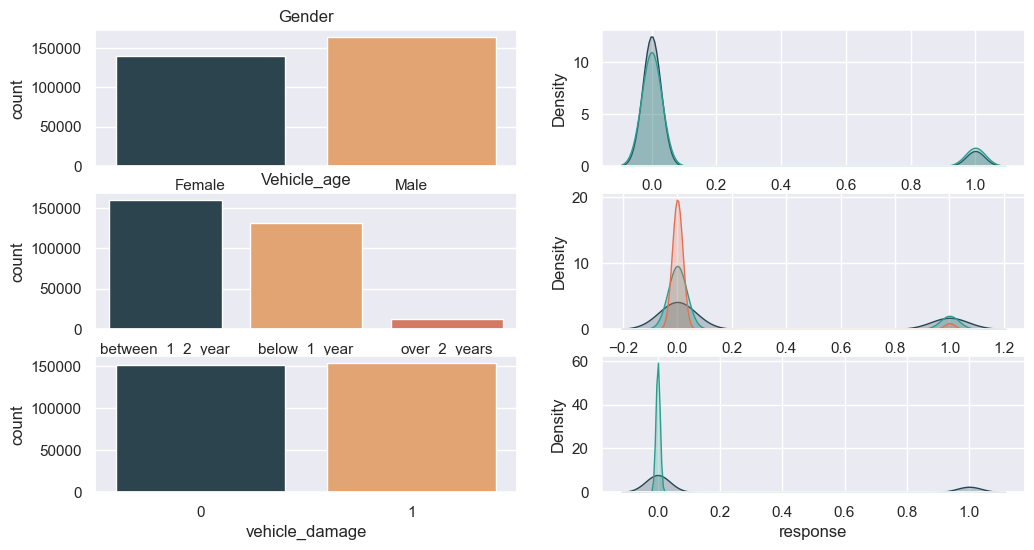

In [24]:
# Gender
plt.subplot( 3, 2, 1 )
plt.title("Gender")
sns.countplot(df2, x='gender', palette=cores)
plt.subplot( 3, 2, 2 )
sns.kdeplot( df2[df2['gender'] == 'Female']['response'], label='Female', fill=True )
sns.kdeplot( df2[df2['gender'] == 'Male']['response'], label='Male', fill=True )

#vehicle_age
plt.subplot( 3, 2, 3 )
plt.title("Vehicle_age")
sns.countplot( df2, x='vehicle_age', palette=cores)
plt.subplot( 3, 2, 4 )
sns.kdeplot(  df2[ df2['vehicle_age'] == 'over_2_years']['response'], label='Loyal Customer', fill=True )
sns.kdeplot( df2[df2['vehicle_age'] == 'between_1_2_year']['response'], label='disloyal Customer', fill=True )
sns.kdeplot( df2[df2['vehicle_age'] == 'below_1_year']['response'], label='disloyal Customer', fill=True )

# vehicle_damage
plt.subplot( 3, 2, 5 )
sns.countplot( df2,  x='vehicle_damage', palette=cores)
plt.subplot( 3, 2, 6 )
sns.kdeplot( df2[df2['vehicle_damage'] == 1 ]['response'], label='Foi Danificado', fill=True )
sns.kdeplot( df2[df2['vehicle_damage'] == 0 ]['response'], label='Não Danificado', fill=True )


### <div style="color:white;display:fill;border-radius:5px;background-color:#e76f51;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:100%">3.2 Análise Bivariada</p></div>

#### H1- Clientes mais novos têm maior interesse em adquirir seguro veicular?

FALSO - O maior interesse pelo seguro está na faixa de idade entre 40 e 50 anos, demonstrando uma procura menor em idades inferiores a 35 anos e superiores aos 55 anos.

Ignoring `palette` because no `hue` variable has been assigned.


Text(0.5, 1.0, 'Idade dos interessados')

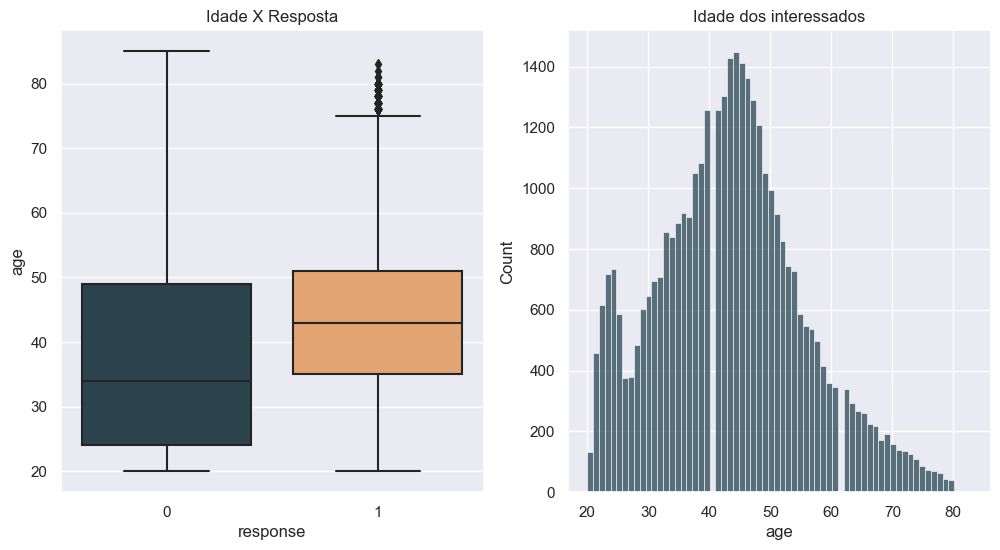

In [25]:
# age
plt.subplot( 1, 2, 1 )
sns.boxplot( data=df2 ,x='response', y='age', palette=cores)
plt.title("Idade X Resposta")

plt.subplot( 1, 2, 2 )
aux0 = df2.loc[df2['response'] == 1 , 'age']
sns.histplot( aux0 , palette=cores)
plt.title("Idade dos interessados")

#### H2- Clientes com CNH têm maior propensão para adquirir o seguro?

VERDADEIRO - A maioria dos clientes que querem o seguro possuem CNH.

<Axes: xlabel='driving_license', ylabel='Count'>

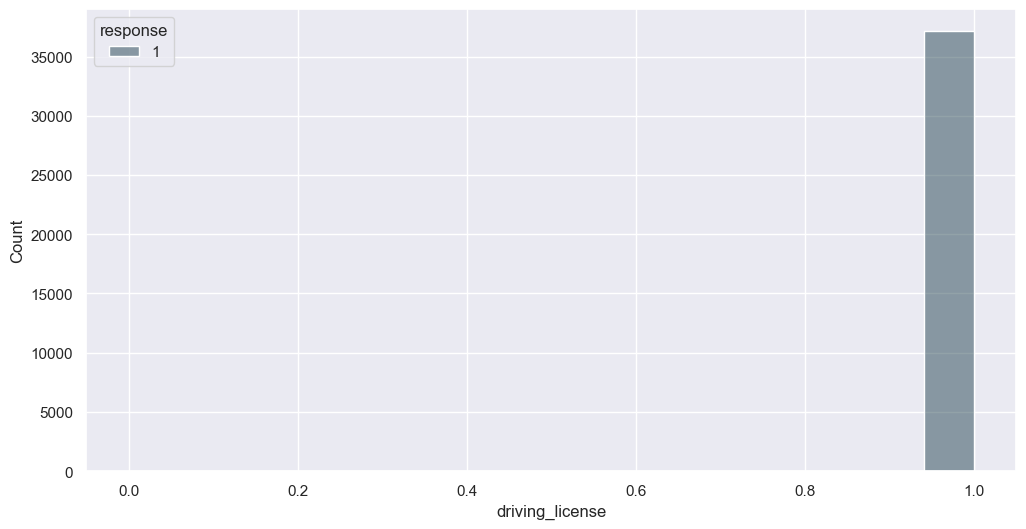

In [26]:
aux = df2.loc[df2['response'] == 1, ['driving_license', 'response']]
sns.histplot( data=aux, x='driving_license',hue='response')

#### H3- Clientes que já possuem seguro são mais propensos a adquirir outro seguro?

FALSO - Basicamente 99% das pessoas que ja possuem seguro não querem um novo seguro.

<Axes: xlabel='previously_insured', ylabel='Count'>

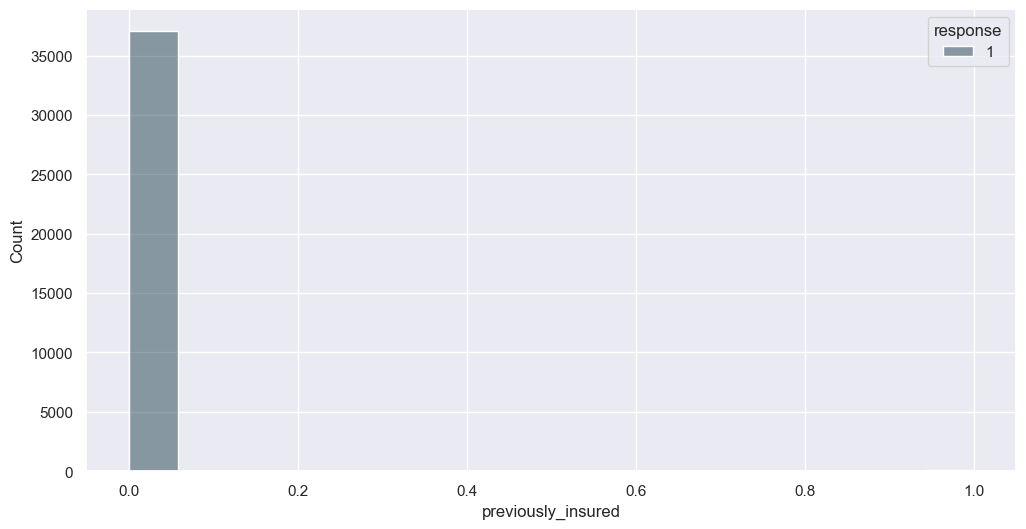

In [27]:
aux = df2.loc[(df2['response'] == 1),['previously_insured','response']]
sns.histplot(x='previously_insured', hue='response', data=aux)

In [28]:
# previously_insured
pd.crosstab( df2['previously_insured'], df2['response'] ).apply( lambda x: x / x.sum(), axis=1)

response,0,1
previously_insured,,
0,0.775547,0.224453
1,0.999127,0.000873


#### H4- O preço do seguro de veículo tem alguma influência? Preços ou planos específicos são fatores importantes para conquistar os clientes?

VERDADEIRO - A uma maioria dos que interessados no seguro se concentra no seguro anual com valor 2630 ou na média proxima a 30000, Demonstrando um padrão que deve representa o plano básico com menor valor, e um plano mais abrangente para carros e idades medianas, visto que são dois fatores de grande influência para o calculo do valor pago pelos assegurados.

Text(0, 0.5, 'Interessados')

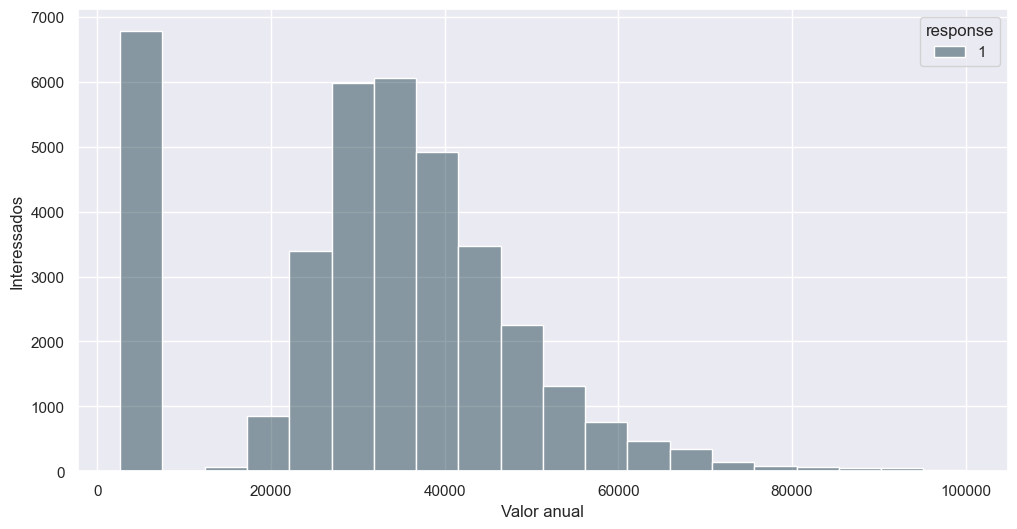

In [29]:
# annual_premium
aux1 = df2.loc[(df2['response'] == 1) & (df2['annual_premium'] < 100000),['annual_premium','response']]
sns.histplot(x='annual_premium', hue='response', data=aux1, bins=20)
plt.xlabel('Valor anual')
plt.ylabel('Interessados')

#### H5- O canal de contato com o cliente tem influência sobre o interesse no seguro ?

VERDADEIRO - Existem formas de contato mais usuais e com maior aceitação por parte do cliente, em um proximo ciclo podemos isolar estes meios de comunicação e identificar suas taxas de sucesso. 

<Axes: xlabel='policy_sales_channel', ylabel='Count'>

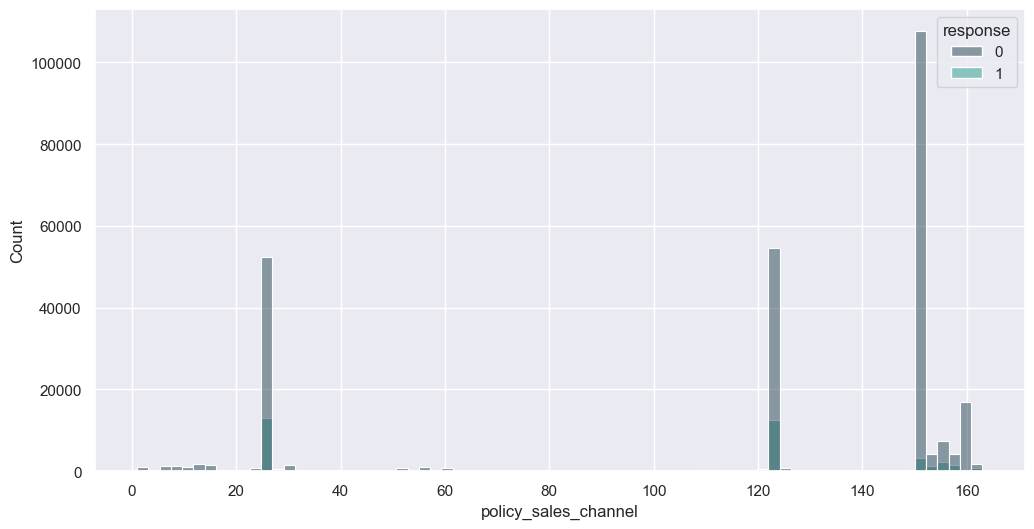

In [30]:
sns.histplot(x='policy_sales_channel', hue='response', data=df2, bins=75)

#### H6- O gênero do cliente pode ser um fator de influência, existe diferença na propensão a adquirir um seguro de veículo?


VERDADEIRO - Dentro os que tem interesse no seguro os homens são maioria.

Text(0, 0.5, 'Interessados')

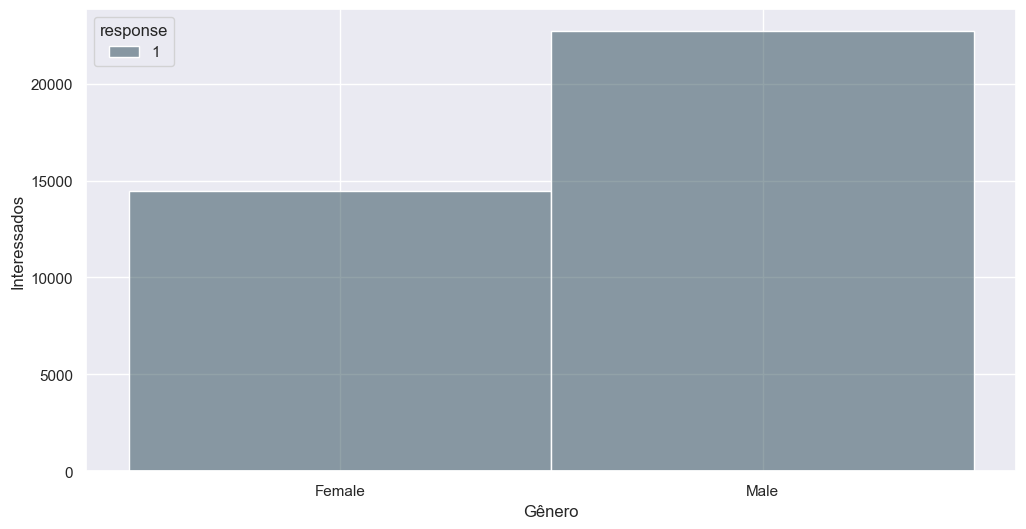

In [31]:
aux = df2.loc[(df2['response'] == 1),['gender','response']]
sns.histplot(data=aux ,x='gender', hue='response')
plt.xlabel('Gênero')
plt.ylabel('Interessados')

### <div style="color:white;display:fill;border-radius:5px;background-color:#e76f51;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:100%">3.3 Análise Multivariada</p></div>

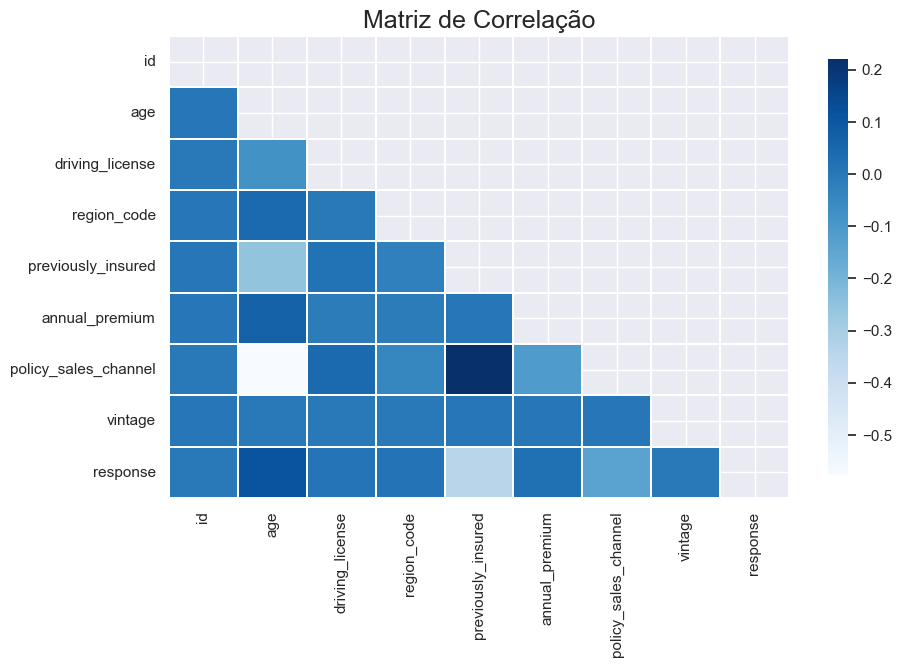

In [32]:
# Cria Matriz de correlação das variaveis numericas
mask = np.zeros_like(num_atributes.corr(), dtype=bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(10, 6))

plt.title('Matriz de Correlação',fontsize=18)
sns.heatmap(num_atributes.corr(),linewidths=0.25,fmt=".2f", cmap="Blues", linecolor='w',annot=False,mask=mask,annot_kws={"size":10},cbar_kws={"shrink": .9});

## <div style="color:white;display:fill;border-radius:5px;background-color:#264653;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:120%">4.0 Data Preparation</p></div>

In [33]:
df3 = df2.copy()

In [34]:
X_train.shape, y_train.shape

((304887, 12), (304887,))

### <div style="color:white;display:fill;border-radius:5px;background-color:#e76f51;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:100%">4.1 Standardization e Rescaling</p></div>

In [35]:
df3 = data_rescaling( df3)

### <div style="color:white;display:fill;border-radius:5px;background-color:#e76f51;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:100%">Encoder</p></div>

In [36]:
df3 = data_encoding( df3)

### <div style="color:white;display:fill;border-radius:5px;background-color:#e76f51;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:100%"> Split Dataframe into Training e Validation</p></div>

In [37]:
X = df3.drop('response', axis=1)
y = df3['response']

X_train, X_val, y_train, y_val = ms.train_test_split( X, y, test_size=0.2, random_state= RANDOM_SEED )

df3 = pd.concat( [X_train, y_train], axis=1)

## <div style="color:white;display:fill;border-radius:5px;background-color:#264653;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:120%">5.0 Feature Selection </p></div>

In [38]:
#data preparation
X_train_fs = df3.drop( 'response', axis=1)
y_train_fs = y_train.values

In [51]:
# Treina modelo simples para entender a importancia de cada feature no modelo 
#lgbm_model = LGBMClassifier()
#lgbm_model.fit(X_train_fs, y_train_fs)
#explainer = shap.Explainer(lgbm_model, X_train_fs)
#shap_values = explainer(X_train_fs)

In [52]:
#explainer = shap.Explainer(rf_model, X_train)
#shap_values = explainer(X_train)

In [53]:
#Inicializa ambiente biblioteca Shap
#shap.initjs()

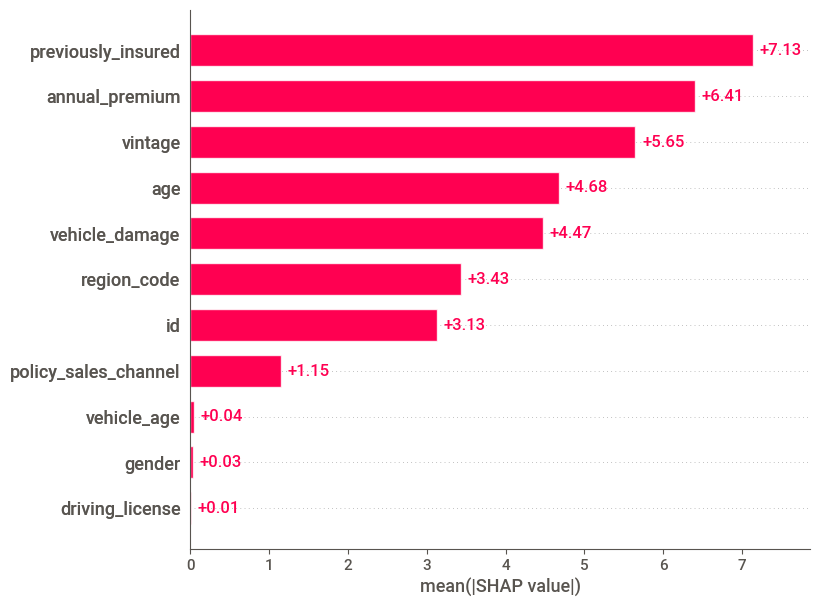

In [41]:
#Explicabilidade Geral, média de contribuição de cada feature para tomada de decisão do modelo
#shap.plots.bar(shap_values, max_display=25)

## <div style="color:white;display:fill;border-radius:5px;background-color:#264653;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:120%">6.0 Machine Learning</p></div>

In [39]:
cols_selected = [ 'age', 'region_code', 'previously_insured', 'vehicle_damage', 'annual_premium','policy_sales_channel', 'vintage']

In [40]:
X_train = df3[ cols_selected]
X_val = X_val[ cols_selected]

**Métricas de avaliação:**

**Curva de ganho cumulativo**: Cruza o percentual da base de clientes com percentual de clientes com propensão de compra ordenados, se eu pegar uma porcentagem X da base estarei alcançando qual porcentagem de pessoas interessadas ?

**Lift Curve**: Demonstra a diferença entre a curva de ganho e a aleatoriedade, explicando quantas vezes meu modelo é melhor comparado a uma lista aleatória.

#### <div style="color:white;display:fill;border-radius:5px;background-color:#f4a261;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:80%"> 6.1 KNN</p></div> 

In [56]:
# Definicao do modelo
#knn_model = nh.KNeighborsClassifier( n_neighbors=7)

# Treinamento do Modelo
#knn_model.fit( X_train, y_train )

# Predição modelo - Poder de generalização
#yhat_knn = knn_model.predict_proba( X_val )

<Axes: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

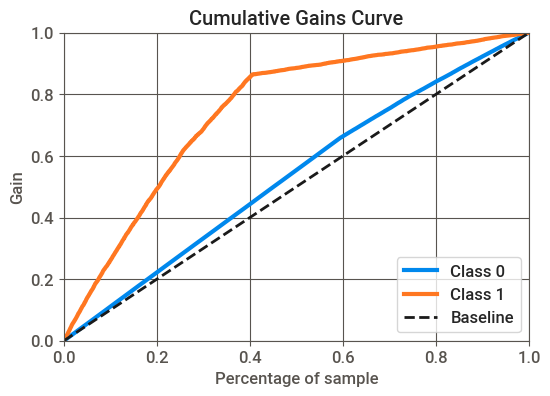

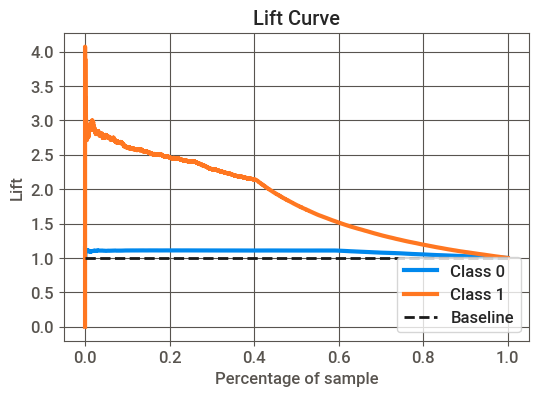

In [48]:
# Gráfico da Curva de ganho cumulatio e curva de lift 
#fig, ax = plt.subplots(figsize=(6, 4))
#skplt.metrics.plot_cumulative_gain(y_val, yhat_knn, ax=ax)
#fig, ax = plt.subplots(figsize=(6, 4))
#skplt.metrics.plot_lift_curve(y_val, yhat_knn, ax=ax )

**Curva de ganho cumulativo**: Com aproximadamente 40% da lista ordenada, cerca de 84% do total de clientes interessados são alcançados.

**Lift Curve**: Com aproximadamente 40% da lista ordenada, o modelo tem um desempenho cerca de 2,1 vezes melhor que uma lista aleatória.


#### <div style="color:white;display:fill;border-radius:5px;background-color:#f4a261;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:80%">6.2 Linear Regression</p></div> 

In [49]:
# Definicao do modelo
#lr_model = lm.LogisticRegression( random_state=42)

# Treinamento do Modelo
#lr_model.fit( X_train, y_train )

# Predição modelo - Poder de generalização
#yhat_lr = lr_model.predict_proba( X_val )

<Axes: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

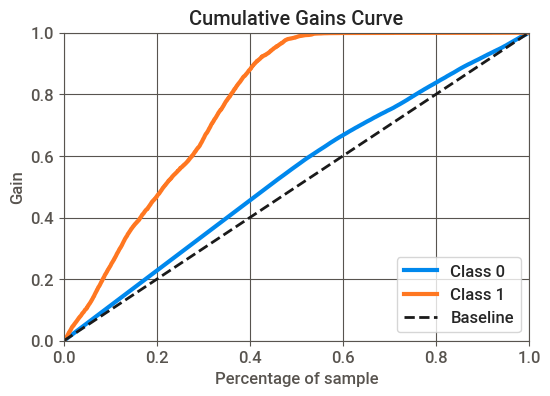

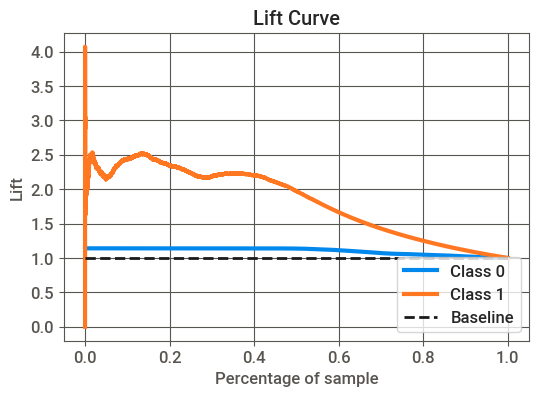

In [50]:
# Gráfico da Curva de ganho cumulatio e curva de lift 
#fig, ax = plt.subplots(figsize=(6, 4))
#skplt.metrics.plot_cumulative_gain(y_val, yhat_lr, ax=ax)
#fig, ax = plt.subplots(figsize=(6, 4))
#skplt.metrics.plot_lift_curve(y_val, yhat_lr, ax=ax )

**Curva de ganho cumulativo**: Com aproximadamente 40% da lista ordenada, cerca de 87% do total de clientes interessados são alcançados.

**Lift Curve**: Com aproximadamente 40% da lista ordenada, o modelo tem um desempenho cerca de 2,2 vezes melhor que uma lista aleatória.


#### <div style="color:white;display:fill;border-radius:5px;background-color:#f4a261;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:80%"> 6.3 Random Forest</p></div> 

In [51]:
# Treina o modelo com os melhores parametros e cria a matriz de confusão e metricas de avaliacao
#rf_model = RandomForestClassifier(random_state=RANDOM_SEED)
# Treinamento do Modelo
#rf_model.fit(X_train,y_train)

# Predição modelo - Poder de generalização
#yhat_rf = rf_model.predict_proba( X_val )

<Axes: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

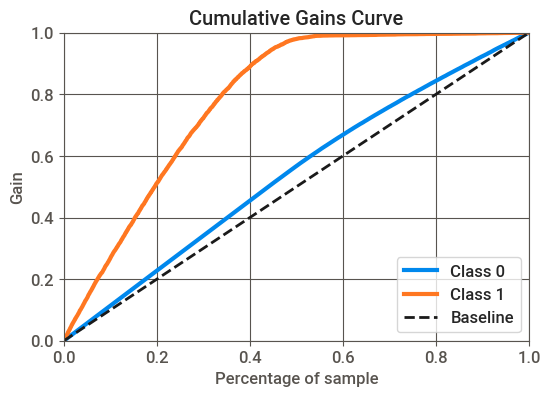

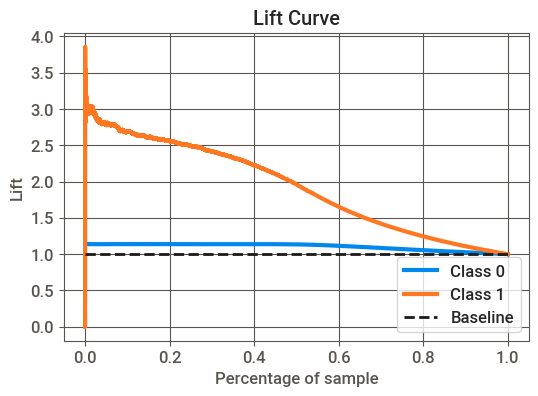

In [52]:
# Gráfico da Curva de ganho cumulatio e curva de lift 
#fig, ax = plt.subplots(figsize=(6, 4))
#skplt.metrics.plot_cumulative_gain(y_val, yhat_rf, ax=ax)
#fig, ax = plt.subplots(figsize=(6, 4))
#skplt.metrics.plot_lift_curve(y_val, yhat_rf, ax=ax )


**Curva de ganho cumulativo**: Com aproximadamente 40% da lista ordenada, cerca de 89% do total de clientes interessados são alcançados.

**Lift Curve**: Com aproximadamente 40% da lista ordenada, o modelo tem um desempenho cerca de 2,2 vezes melhor que uma lista aleatória.


#### <div style="color:white;display:fill;border-radius:5px;background-color:#f4a261;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:80%">6.4 XGboost</p></div> 

In [47]:
# Definicao do modelo
#xgb_model = XGBClassifier(random_state=RANDOM_SEED)
# Treinamento do Modelo
#xgb_model.fit( X_train, y_train )

# Predição modelo - Poder de generalização
#yhat_xgb = xgb_model.predict_proba( X_val )

<Axes: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

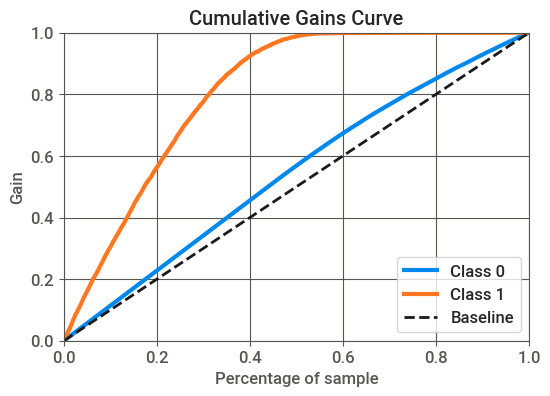

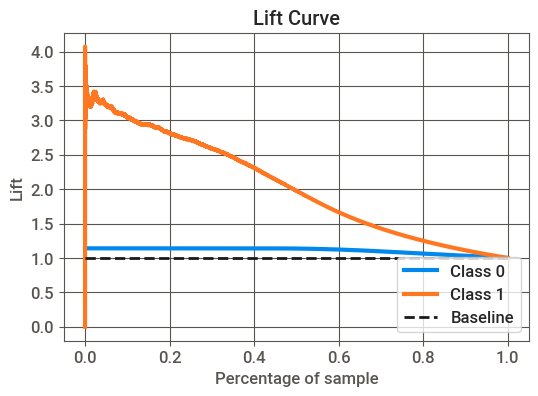

In [48]:
# Gráfico da Curva de ganho cumulatio e curva de lift 
#fig, ax = plt.subplots(figsize=(6, 4))
#skplt.metrics.plot_cumulative_gain(y_val, yhat_xgb, ax=ax)
#fig, ax = plt.subplots(figsize=(6, 4))
#skplt.metrics.plot_lift_curve(y_val, yhat_xgb, ax=ax )

**Curva de ganho cumulativo**: Com aproximadamente 40% da lista ordenada, cerca de 92% do total de clientes interessados são alcançados.

**Lift Curve**: Com aproximadamente 40% da lista ordenada, o modelo tem um desempenho cerca de 2,3 vezes melhor que uma lista aleatória.


#### <div style="color:white;display:fill;border-radius:5px;background-color:#f4a261;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:80%"> 6.5 Model Performance</p></div> 

**AUC ROC, Precisão e Recall em top k ( k=4000 )**

ROC AUC no top K: Indica que o modelo é mais eficaz em classificar corretamente os k principais resultados.

Precisão no top k: Conta quantas previsões foram corretas até k e divide por todas as previsões feitas até k.

Recall at top k: Conta quantas previsões estavam corretas até k e divide por todos os exemplos verdadeiros.




In [49]:
# Tabela com métricas de cada modelo
#metrica_knn = modelo_metricas('KNN Classifier', y_val, yhat_knn, X_val)
#metrica_lr = modelo_metricas('Logistic Regression', y_val, yhat_lr, X_val)
#metrica_rf = modelo_metricas('Random Forest Classifier', y_val, yhat_rf, X_val)
#metrica_xgb = modelo_metricas('XGBoost Classifier', y_val, yhat_xgb, X_val)
#metrics_all = pd.concat([metrica_knn, metrica_lr, metrica_rf, metrica_xgb], axis=0)
#metrics_all.sort_values(by='ROC AUC at K', ascending=False)

,Model Name,ROC AUC at K,Precisão at K,Recall at K
0,XGBoost Classifier,0.851809,0.388903,0.207799
0,Random Forest Classifier,0.828113,0.343164,0.183360
0,Logistic Regression,0.814105,0.275931,0.147436
0,KNN Classifier,0.781942,0.331917,0.177350


#### <div style="color:white;display:fill;border-radius:5px;background-color:#f4a261;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:80%"> 6.6 Cross-validation</p></div> 

In [63]:
# Faz a validação cruzada para modelos
#model_list = [ XGBClassifier(), RandomForestClassifier(), lm.LogisticRegression( random_state=42), nh.KNeighborsClassifier( n_neighbors=7)]
#model_name = ['XGBoost Classifier', 'Random Forest Classifier', 'Logistic Regression', 'KNN Classifier' ]

#cross_concat = pd.DataFrame()
#cross_list = []

#for i, name in zip(model_list, model_name):
    
#   cross_val = cross_validation(X_train, y_train, 5, name, i)
#   cross_list.append(cross_val)

#df_cross_val = pd.concat(cross_list, ignore_index=True) 

In [64]:
# Retorna ROC AUC média e desvios padrão para cada algoritmo
#df_cross_val = df_cross_val.drop( ['Precisão at K', 'Recall at K'], axis=1)
#round(df_cross_val.groupby('Model Name').agg(['mean', 'std']).reset_index().sort_values(by=('ROC AUC at K','mean'), ascending=False),4)

Model Name ROC AUC at K        
                                    mean     std
3        XGBoost Classifier       0.8498  0.0018
2  Random Forest Classifier       0.8287  0.0013
1       Logistic Regression       0.8120  0.0018
0            KNN Classifier       0.7780  0.0024

Nota-se que após o Cross-validation os valores apresentados nas métricas são próximos aos de treino, o que demonstra uma boa performance do modelo, pois não apresenta Overfiting ou Underfiting.

## <div style="color:white;display:fill;border-radius:5px;background-color:#264653;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:120%">7.0 Hiperparameter Fine Tuning</p></div>

De acordo com as métricas o modelo escolhido foi o XGboost.

#### <div style="color:white;display:fill;border-radius:5px;background-color:#f4a261;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:80%">7.1 XGboost Hiperparameter</p></div> 

In [44]:
# Função de otimização de hiperametros em conjunto com a biblioteca Optuna
def objective(trial): 
    
    param_grid = {
        'objective': trial.suggest_categorical('objective', ['binary:logistic']),  
        'booster': trial.suggest_categorical('booster', ['gbtree','dart']),
        'eval_metric': trial.suggest_categorical('eval_metric', ['auc']),    
        'max_depth': trial.suggest_int('max_depth', 6, 18),
        #'learning_rate': trial.suggest_categorical('learning_rate', [0.1]),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 0.40),
        'n_estimators' : trial.suggest_int('n_estimators', 60, 250, step=20),
        'alpha': trial.suggest_float('alpha', 1e-4, 1e-1, log=True),
        'lambda': trial.suggest_float('lambda', 1e-4, 1e-1, log=True),
        'seed': trial.suggest_categorical('seed', [RANDOM_SEED]),     
    }

    model = XGBClassifier(**param_grid)
    number_folds = 3
    Kfold = StratifiedKFold(n_splits=number_folds, shuffle=True) #random_state=RANDOM_SEED
    y_pred = cross_val_predict(model, X_train, y_train, cv=Kfold)
    
    return roc_auc_score(y_train,y_pred)

In [43]:
# Executa a função de otimização e retorna a melhor combinação de valor dos hiperparametros apos n_trials
#study = optuna.create_study(direction='maximize')
#optuna.logging.set_verbosity(optuna.logging.WARNING)
#study.optimize(objective, n_trials=50) 

#trial = study.best_trial

In [ ]:
# Print the result
#xgb_best_params = study.best_params
#xgb_best_score = study.best_value
#print(f"Best score: {xgb_best_score}\n")
#print(f"Optimized parameters: {xgb_best_params}\n")

In [53]:
xgb_best_params_revised = {'objective': 'binary:logistic',
 'booster': 'gbtree',
 'eval_metric': 'auc',
 'max_depth': 7,
 'learning_rate': 0.24262609058553683,
 'n_estimators': 120,
 'alpha': 0.00163,
 'lambda': 0.00243,
 'seed': 42}

In [54]:
# Definicao do modelo
#xgb_model_tunned = XGBClassifier(**xgb_best_params_revised)
# Treinamento do Modelo
#xgb_model_tunned.fit( X_train, y_train )

# Predição modelo - Poder de generalização
#yhat_xgb_tunned = xgb_model_tunned.predict_proba( X_val )

In [47]:
#metrica_xgb_tunned = modelo_metricas('XGBoost Classifier Tunned', y_val, yhat_xgb_tunned, X_val)
#metrica_xgb_tunned

,Model Name,ROC AUC at K,Precisão at K,Recall at K
0,XGBoost Classifier Tunned,0.849421,0.377656,0.20179


## <div style="color:white;display:fill;border-radius:5px;background-color:#264653;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:120%">8.0 Testing Model Performance</p></div>

In [41]:
x_test = X_test.copy()

In [42]:
# Aplica transformações aos dados de teste
rename_columns( x_test)
feature_engineering( x_test)
data_encoding( x_test)
data_rescaling( x_test)
x_test = x_test.loc[:,cols_selected]

In [43]:
x = X[cols_selected]

In [51]:
#training on total dataset
#xgb_model_tunned.fit(x, y)

#yhat_xgb_final = xgb_model_tunned.predict_proba( x_test)

In [52]:
#X_test_val = X_test.copy()
#X_test_val['response'] = y_val.copy()

In [53]:
#metrica_xgb_final = modelo_metricas('XGBoost Classifier Final', y_test, yhat_xgb_final, X_test_val)
#metrica_xgb_final

,Model Name,ROC AUC at K,Precisão at K,Recall at K
0,XGBoost Classifier Final,0.842201,0.371157,0.155938


<Axes: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

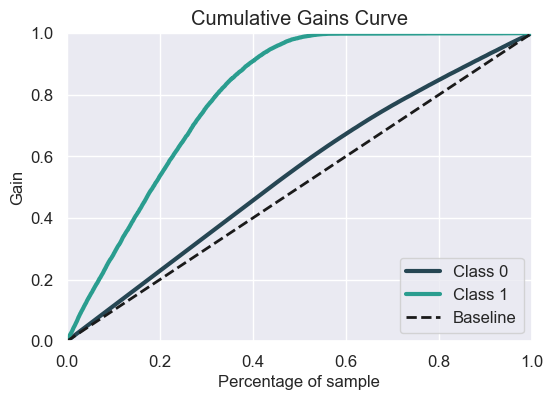

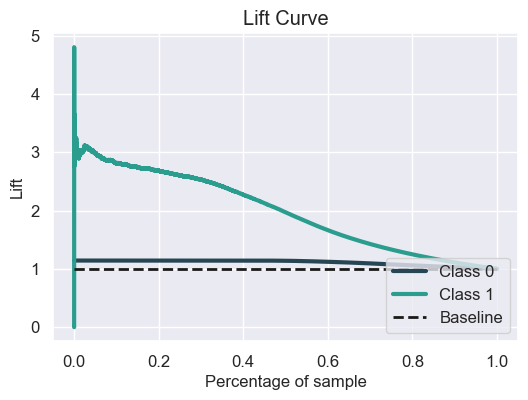

In [54]:
# Gráfico da Curva de ganho cumulatio e curva de lift 
#fig, ax = plt.subplots(figsize=(6, 4))
#skplt.metrics.plot_cumulative_gain(y_test, yhat_xgb_final, ax=ax)
#fig, ax = plt.subplots(figsize=(6, 4))
#skplt.metrics.plot_lift_curve(y_test, yhat_xgb_final, ax=ax )

Ao testar o modelo com dados nunca vistos, conclui-se que ele apresenta uma boa capacidade de generalização, que significa que ele aprendeu com os dados de treino e consegue fazer uma previsão precisa para dados que nunca viu.

#### <div style="color:white;display:fill;border-radius:5px;background-color:#f4a261;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: left;margin:0;font-size:80%">8.1 Business Performance</p></div> 

Temos uma base ranqueada pela propensão de compra em porcentagem com 76.220 clientes, Neste cenário, queremos atingir o maior número de interessados no seguro veicular entrando em contado com o menor número possível de clientes. Supondo que os clientes com maior interesse irão fechar o contrato, e o valor médio anual do seguro veicular é o mesmo do seguro de saúde, no valor de  R$ 30.572

Utilizando como base a curva de ganho cumulativo do modelo treinado, usaremos como ponto de comparação o ponto de 40% da base de clientes e comparar os cenários de faturamento do modelo treinado com a aleatoriedade. Temos a seguinte comparação:

**Lista aleatoria**: Contatando 40% da base na aleatoriedade, temos 40% dos interessados em seguro de automoveis.

**Lista ordenada( Modelo)**: Contatando 40% da base ordenada, temos 92% dos interessados em seguro de automoveis.



In [44]:
perc_base_clientes = (X_test['id'].count() * 0.4)
media_seguro_veicular = X_test['Annual_Premium'].mean()

In [46]:
lista_aleat = round(perc_base_clientes * 0.4 * media_seguro_veicular,2)
lista_modelo = round(perc_base_clientes * 0.92 * media_seguro_veicular,2)
total_ganho = lista_modelo - lista_aleat
vezes_ganho = lista_modelo / lista_aleat

In [47]:
print(f'Faturamento estimado na aleatoriadade: R$ {lista_aleat:.2f}')
print(f'Faturamento estimado com o modelo: R$ {lista_modelo:.2f}')
print(f'Ganho de faturamento com o modelo treinado: R$ {total_ganho:.2f}')
print(f'O faturamento é {vezes_ganho:.1f} vezes maior com o modelo.')

Faturamento estimado na aleatoriadade: R$ 372384626.56
Faturamento estimado com o modelo: R$ 856484641.09
Ganho de faturamento com o modelo treinado: R$ 484100014.53
O faturamento é 2.3 vezes maior com o modelo.
